<a href="https://colab.research.google.com/github/AdrianCobo/Deep-Learning-And-Artificial-Intelligence/blob/main/L6_Non_Linear_Sequence_GRU_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [76]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time sereis of the form x(t) = sin(wt^2)

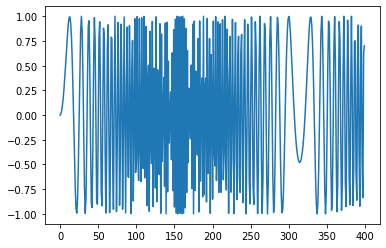

In [77]:
# plot it
plt.plot(series)
plt.show()

In [78]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T ,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [79]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [80]:
### Define simple RNN
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs 
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.GRU(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
  
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [81]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [82]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [83]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [84]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss 
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses




In [85]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [86]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.5115, Test Loss: 0.6303
Epoch  10/200, Train Loss: 0.5028, Test Loss: 0.6253
Epoch  15/200, Train Loss: 0.4965, Test Loss: 0.5735
Epoch  20/200, Train Loss: 0.4895, Test Loss: 0.6046
Epoch  25/200, Train Loss: 0.4751, Test Loss: 0.5983
Epoch  30/200, Train Loss: 0.4262, Test Loss: 0.5229
Epoch  35/200, Train Loss: 0.3604, Test Loss: 0.4765
Epoch  40/200, Train Loss: 0.2652, Test Loss: 0.4179
Epoch  45/200, Train Loss: 0.1445, Test Loss: 0.2957
Epoch  50/200, Train Loss: 0.0756, Test Loss: 0.2380
Epoch  55/200, Train Loss: 0.0526, Test Loss: 0.1622
Epoch  60/200, Train Loss: 0.0342, Test Loss: 0.1174
Epoch  65/200, Train Loss: 0.0197, Test Loss: 0.0825
Epoch  70/200, Train Loss: 0.0148, Test Loss: 0.0547
Epoch  75/200, Train Loss: 0.0104, Test Loss: 0.0498
Epoch  80/200, Train Loss: 0.0078, Test Loss: 0.0455
Epoch  85/200, Train Loss: 0.0059, Test Loss: 0.0411
Epoch  90/200, Train Loss: 0.0050, Test Loss: 0.0383
Epoch  95/200, Train Loss: 0.0046, Test Loss: 0

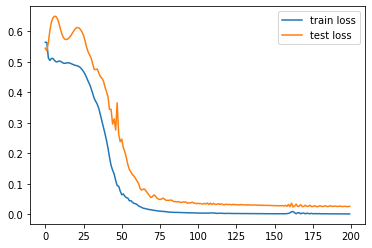

In [87]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [88]:
# One step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

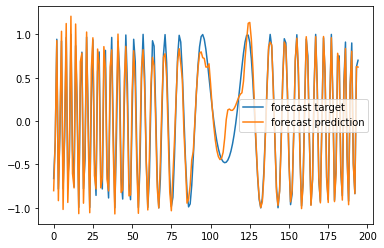

In [89]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [90]:
# Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

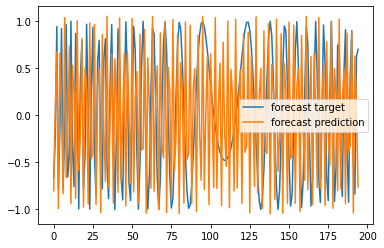

In [91]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()